# Question: Are actively managed mutual funds a better investment than passively managed mutual funds?

# Project Outline

    - Pull Data
     - Describe Data

# Important Links:

## CRSP Data Definitions
## http://www.crsp.com/products/documentation/data-definitions-2


## JP Morgan - Active vs Passive Funds
## https://www.morganstanley.com/spc/knowledge/managing-wealth/wealth-management-for-stock-plan-participants/active-vs--passive-funds--its-more-than-just-fees.html

## Mutual Fund Performance Measures
## https://web.stanford.edu/~wfsharpe/art/mfpm/mfpm.htm

**********************************************************************************************************************

# NOTE: To see results, please go to the Visualization/Conclusion Section

**********************************************************************************************************************

# Import Modules

In [1]:
import pandas as pd
import numpy as np
import requests
import json
import re
import seaborn as sns
import time
from scipy.stats import norm
from matplotlib import pyplot as plt
import random
import datetime
from fund_analysis import *






# Import Data

In [2]:
start = pd.to_datetime('01/01/1988')
end = pd.to_datetime('04/16/2018')

In [3]:
data = pd.read_csv('CRSP.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (5,12,49,50,51,62,65,66) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
sp_data = get_yahoo_prices('^GSPC', start, end)

In [5]:
sp_data = sp_data.reset_index()

In [6]:
sp_data = sp_data[['date', 'adjclose']]

In [7]:
active_price = pd.read_csv('active_price_data.csv')
passive_price = pd.read_csv('passive_price_data.csv')

# Cleaning/Preparation

### CRSP Data

In [8]:
data.shape

(550596, 73)

In [9]:
data.columns

Index(['summary_period2', 'crsp_fundno', 'caldt', 'nav_latest',
       'nav_latest_dt', 'tna_latest', 'tna_latest_dt', 'yield', 'div_ytd',
       'cap_gains_ytd', 'nav_52w_h', 'nav_52w_h_dt', 'nav_52w_l',
       'nav_52w_l_dt', 'unrealized_app_dep', 'unrealized_app_dt', 'asset_dt',
       'per_com', 'per_pref', 'per_conv', 'per_corp', 'per_muni', 'per_govt',
       'per_oth', 'per_cash', 'per_bond', 'per_abs', 'per_mbs', 'per_eq_oth',
       'per_fi_oth', 'maturity', 'maturity_dt', 'cusip8', 'crsp_portno',
       'crsp_cl_grp', 'fund_name', 'ticker', 'ncusip', 'mgmt_name', 'mgmt_cd',
       'mgr_name', 'mgr_dt', 'adv_name', 'open_to_inv', 'retail_fund',
       'inst_fund', 'm_fund', 'index_fund_flag', 'vau_fund', 'et_flag',
       'delist_cd', 'first_offer_dt', 'end_dt', 'dead_flag', 'merge_fundno',
       'actual_12b1', 'max_12b1', 'exp_ratio', 'mgmt_fee', 'turn_ratio',
       'fiscal_yearend', 'crsp_obj_cd', 'si_obj_cd', 'accrual_fund',
       'sales_restrict', 'wbrger_obj_cd', 'poli

In [10]:
df = pd.DataFrame({'Fund Name' : data['fund_name'], 'Fund Ticker' : data['ticker'], 
                   'Open to Investors' : data['open_to_inv'], 'Expense Ratio' : data['exp_ratio'],
                  'Management Fee' : data['mgmt_fee'], 'Turnover Ratio' : data['turn_ratio']})

In [11]:
df.isnull().sum()

Expense Ratio         77314
Fund Name              7823
Fund Ticker           86503
Management Fee       144968
Open to Investors     81168
Turnover Ratio        77314
dtype: int64

In [12]:
df.dropna(inplace = True)

In [13]:
df['Turnover Ratio'].describe()

count    371785.000000
mean         -5.379646
std         182.354466
min         -99.000000
25%           0.210000
50%           0.490000
75%           0.990000
max      110120.080000
Name: Turnover Ratio, dtype: float64

In [14]:
df['Active or Passive'] = df['Expense Ratio'].apply(managed)
df['Active or Passive'] = df['Turnover Ratio'].apply(managed_turn)

In [15]:
df = df[df['Open to Investors'] == 'Y']

In [16]:
df = df[df['Management Fee'] > 0]

In [17]:
df = df[df['Expense Ratio'] > 0]

In [18]:
df.drop_duplicates(subset = ['Fund Ticker'], inplace = True)

In [19]:
df.shape

(39653, 7)

In [20]:
df['Active or Passive'].value_counts()

active     30680
passive     8973
Name: Active or Passive, dtype: int64

In [21]:
df_active = df[df['Active or Passive'] == 'active']
df_passive = df[df['Active or Passive'] != 'active']

### Active/Passive Price Data

In [22]:
active_price = active_price.iloc[:, 1:]
passive_price = passive_price.iloc[:, 1:]

In [23]:
active_price.set_index('date', inplace= True)
passive_price.set_index('date', inplace= True)

In [24]:
active_price.dropna(thresh = 1, inplace= True)
passive_price.dropna(thresh = 1, inplace= True)

In [25]:
sp_data = sp_data.set_index('date')

# Analysis

### Returns

In [26]:
sp_rets = pd.DataFrame(sp_data['adjclose'].pct_change())
active_rets = active_price.pct_change()
passive_rets = passive_price.pct_change()

In [27]:
active_rets['sp_data'] = sp_rets['adjclose']
passive_rets['sp_data'] = sp_rets['adjclose']

In [28]:
for col in active_rets.columns:
    try:
        active_rets[col] = active_rets[col] - active_rets['sp_data']    
    except:
        active_rets.drop(col, inplace = True)

In [29]:
for col in passive_rets.columns:
    try:
        passive_rets[col] = passive_rets[col] - passive_rets['sp_data']    
    except:
        passive_rets.drop(col, inplace = True)

In [30]:
active_rets.drop('sp_data', axis = 1, inplace = True)
passive_rets.drop('sp_data', axis = 1, inplace = True)

In [31]:
active_rets['average'] = active_rets.mean(axis = 1)
passive_rets['average'] = passive_rets.mean(axis = 1)


In [32]:
sp_std = sp_rets.rolling(252).std()
sp_rets = sp_rets.rolling(252).mean()

act_std = active_rets['average'].rolling(252).std()
act_rets = active_rets['average'].rolling(252).mean()

pas_std = passive_rets['average'].rolling(252).std()
pas_rets = passive_rets['average'].rolling(252).mean()

In [33]:
act_rets.dropna(how = 'all', inplace= True)

In [34]:
pas_rets.dropna(how = 'all', inplace= True)

In [35]:
act_rets_all = active_rets.rolling(252).mean()
pas_rets_all = passive_rets.rolling(252).mean()

In [36]:
act_rets*= 1000
pas_rets*= 1000
sp_rets['adjclose']*= 1000

### Number of Active vs Passive Funds

In [37]:
active = len(df_passive)
passive = len(df_active)

total = active + passive
act = round(100*(active/total),2)
pas = round(100*(passive/total),2)

### Management fees - Active vs Passive Funds

In [38]:
avg_active = round(df_active['Management Fee'].mean(),3)
avg_passive = round(df_passive['Management Fee'].mean(),3)


### Expense Ratio - Active vs Passive

In [39]:
avg_active_exp = round(df_active['Expense Ratio'].mean(),3)
avg_passive_exp = round(df_passive['Expense Ratio'].mean(),3)

### Top Active Mutual Funds

In [40]:
r = active_rets.drop('average', axis = 1).mean(axis = 0)
r = r.nlargest(10)
r *= 100

### Top Passive Mutual Funds

In [41]:
g = passive_rets.drop('average', axis = 1).mean(axis = 0)
g = g.nlargest(10)
g *= 100

# Visualization

In [42]:
active_mgmt = df_active['Management Fee']
pass_mgmt = df_passive['Management Fee']
active_exp = df_active['Expense Ratio']
pass_exp = df_passive['Expense Ratio']

In [43]:
df_active.loc[:,'Expense Ratio'] *= 100
df_passive.loc[:,'Expense Ratio'] *= 100

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Distribution of Fund Management Fee's

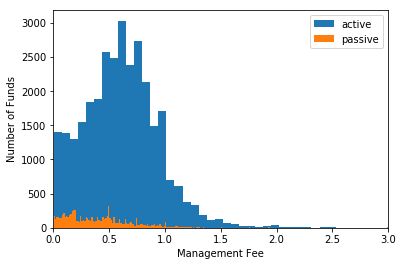

In [44]:
plt.hist(active_mgmt, bins = 500, label='active')
plt.hist(pass_mgmt, bins = 500, label='passive')
plt.xlabel('Management Fee')
plt.ylabel('Number of Funds')
plt.legend(loc='upper right')
plt.xlim(0,3)
plt.show()

### Distribution of Fund Expense Ratio's

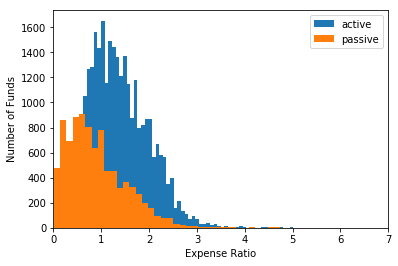

In [45]:
plt.hist(active_exp, bins = 700, label='active')
plt.hist(pass_exp, bins = 50, label='passive')
plt.xlabel('Expense Ratio')
plt.ylabel('Number of Funds')
plt.legend(loc='upper right')
plt.xlim(0,7)
plt.show()

### Active VS Passive Mutual Fund Returns Over Time

In [57]:
act_rets.index = pd.to_datetime(act_rets.index)
pas_rets.index = pd.to_datetime(pas_rets.index)

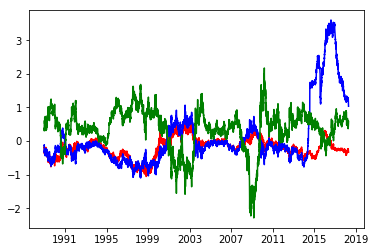

In [61]:
plt.plot(act_rets, color = 'r')
plt.plot(pas_rets, color = 'b')
plt.plot(sp_rets, color = 'g')

# Conclusion

In [48]:
# NOTE : THIS IS FOR THE WHOLE DATASET

print('Average management fee for actively managed funds: {}%'.format(avg_active))
print('Average management fee for passively managed funds: {}%'.format(avg_passive))

Average management fee for actively managed funds: 0.611%
Average management fee for passively managed funds: 0.414%


In [49]:
# NOTE : THIS IS FOR THE WHOLE DATASET

print('There are {} ({}%) actively managed mutual funds'.format(active, act))
print('There are {} ({}%) passively managed mutual funds'.format(passive, pas))

There are 8973 (22.63%) actively managed mutual funds
There are 30680 (77.37%) passively managed mutual funds


In [50]:
# NOTE : THIS IS FOR THE WHOLE DATASET

print('Average expense ratio for actively managed funds: {}%'.format(avg_active_exp))
print('Average expense ratio for passively managed funds: {}%'.format(avg_passive_exp))

Average expense ratio for actively managed funds: 0.013%
Average expense ratio for passively managed funds: 0.009%


In [51]:
print('The top 10 active mutual funds and their average annual returns are:')
print(r)

The top 10 active mutual funds and their average annual returns are:
UBIO     4.142635
FVC      0.791529
PSDKX    0.621025
PFAPX    0.611398
PFATX    0.456357
PQICX    0.182619
CSQIX    0.168508
TNA      0.140785
BEMSX    0.131291
SMAVX    0.091094
dtype: float64


In [52]:
# NOTE: There are data quality issues with yahoo finance
# ex. yahoo finance shows that the ticker 'RSW' which we classified as passive has no data on it
# But if we look at the data we have on it:

passive_price['RSW'].dropna()

# We see that yahoo finance has data for two days

date
2016-01-27    17.73
2016-07-26    24.07
Name: RSW, dtype: float64

In [53]:
print('The top 10 passive mutual funds and their average annual returns are:')
print(g)

The top 10 passive mutual funds and their average annual returns are:
RSW      35.726325
SKK       9.272849
UWPSX     9.080606
UUPSX     5.558224
IFV       5.186953
AFBSX     5.016365
GMRPX     3.957304
GDXX      3.075339
RYCBX     2.472081
IPK       2.416357
dtype: float64
